# Claimable Liquidity from V3 Pool

In [1]:
%reload_ext credmark.cmf.ipython

cmf_param = {
    'chain_id': 1,
    'block_number': None,
    'chain_to_provider_url': {},
    'api_url': None,
    'use_local_models': None,
    'register_utility_global': True}

context, model_loader = %cmf cmf_param

In [2]:
load_from_ledger = False

pool = Contract(address='0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640')

if load_from_ledger:
    with pool.ledger.events.Mint as q:
        df_mint = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        limit=5000
                        ).to_dataframe()

    with pool.ledger.events.Burn as q:
        df_burn = q.select(columns=q.columns,
                        order_by=q.EVT_BLOCK_NUMBER.comma_(q.EVT_INDEX),
                        limit=5000).to_dataframe()

    df_mint.to_csv('csv/uni_mint_5k.csv', index=False)
    df_burn.to_csv('csv/uni_burn_5k.csv', index=False)
else:
    df_mint = pd.read_csv('csv/uni_mint_5k.csv')
    df_burn = pd.read_csv('csv/uni_burn_5k.csv')


df_mint = df_mint.query('evt_block_number <= 12823596')
df_burn = df_burn.query('evt_block_number <= 12823596')

In [3]:
df_mintburn = (pd
    .concat([df_mint.assign(type='mint', inp_amount = lambda x: x.inp_amount.apply(int)),
             df_burn.assign(type='burn', inp_amount = lambda x: -x.inp_amount.apply(int))])
    .sort_values(['evt_block_number', 'evt_index'])
    .reset_index(drop=True))

df_mintburn_idx = df_mintburn.set_index(['inp_tickLower', 'inp_tickUpper', 'inp_owner']).sort_index()

display(df_mintburn)
display(('Unique owners', df_mintburn.inp_owner.unique().tolist()))
display(('Unique sender', df_mintburn.inp_sender.unique().tolist()))

,contract_address,evt_block_number,evt_tx_hash,evt_index,inp_sender,inp_owner,inp_tickLower,inp_tickUpper,inp_amount,inp_amount0,inp_amount1,type
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376729,0x125e0b641d4a4b08806bf52c0c6757648c9963bcda86...,106,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,345073104699360,2995507735,999999999871526563,mint
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376958,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,122,NaN,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,-310565794229424,2588187276,931484249884373906,burn
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376958,0x7258050fbb90fa41f73505c552a973113ffc87c67ddd...,124,NaN,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,191150,198080,0,0,0,burn
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12377035,0xa564ea4677bda271bbb2eebec9774577b9b101c46eaf...,195,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,194990,195010,25652705721581,1000000,145737680853531,mint
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12377266,0xef93747acabe06ab11f663321f0de466bf9ae35888ba...,286,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,186730,195460,447994594415865,598469729,2599999995846641821,mint
...,...,...,...,...,...,...,...,...,...,...,...,...
9243,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12823588,0x0f215e289b6060ac7479872f6c3cb9da3490a86577ec...,185,NaN,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,200880,201030,-4298521855200525,956691230,233074979405963317,burn
9244,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12823588,0x0f215e289b6060ac7479872f6c3cb9da3490a86577ec...,191,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,200870,201030,3546402272827868,789297361,233074979405963283,mint
9245,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12823588,0x0f215e289b6060ac7479872f6c3cb9da3490a86577ec...,193,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,0xf5F30EaF55Fd9fFc70651b13b791410aAd663846,200930,201030,774101406351911,167393869,0,mint
9246,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12823596,0x84491d7e116e8c267889a52f7c73db425ace4f68f69c...,11,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,200900,200910,365917254861716766083,7942416453334,0,mint


('Unique owners',
 ['0xC36442b4a4522E871399CD717aBDD847Ab11FE88',
  '0xa0127ad0f03bd1CE1D68d4820246db40F16C5688',
  '0x26f655245589eAc80f3F8e288A77e25899674a49',
  '0xd8C5e675f3D9Fa5F55f86eee5BB81D159D461eC9',
  '0x6f3F35a268B3af45331471EABF3F9881b601F5aA',
  '0x325441FdB3bd45a8093994303cF9B67f3689aC11',
  '0xB8B03BefFe0A033B11946F65cc6DD9767d5Ec936',
  '0x5e4aEc4E2eC0dF9d5C6433b03af20d7386A4678E',
  '0x5eDa709CAf6c57391F2Ac82BD39A4ef9DE181650',
  '0x2CB9a670EB42cf86a47b9eFDB318f402Ad06188e',
  '0xBFdf08b1B5b28cA1a0FED5edbd8943685569e382',
  '0x0507856599f598d2aA070c4286D296CD7Ef7AF9a',
  '0xB7E6E197792737a7DDD5F175421532F5616E1D7a',
  '0x215852Cc03263496969d8a5daa96f569B176771f',
  '0x759704b23a25bC8cdb90859D9D99Fe45a58031A4',
  '0x6fb6a8383574cA2da4f7d1c1B52b423eeD383752',
  '0x6c57F51f88b1898967734d8117c854C15810fF40',
  '0xf5F30EaF55Fd9fFc70651b13b791410aAd663846'])

('Unique sender',
 ['0xC36442b4a4522E871399CD717aBDD847Ab11FE88',
  nan,
  '0xa0127ad0f03bd1CE1D68d4820246db40F16C5688',
  '0x26f655245589eAc80f3F8e288A77e25899674a49',
  '0xd8C5e675f3D9Fa5F55f86eee5BB81D159D461eC9',
  '0x6f3F35a268B3af45331471EABF3F9881b601F5aA',
  '0x325441FdB3bd45a8093994303cF9B67f3689aC11',
  '0xB8B03BefFe0A033B11946F65cc6DD9767d5Ec936',
  '0x5e4aEc4E2eC0dF9d5C6433b03af20d7386A4678E',
  '0x5eDa709CAf6c57391F2Ac82BD39A4ef9DE181650',
  '0x2CB9a670EB42cf86a47b9eFDB318f402Ad06188e',
  '0xBFdf08b1B5b28cA1a0FED5edbd8943685569e382',
  '0x0507856599f598d2aA070c4286D296CD7Ef7AF9a',
  '0xB7E6E197792737a7DDD5F175421532F5616E1D7a',
  '0x215852Cc03263496969d8a5daa96f569B176771f',
  '0x759704b23a25bC8cdb90859D9D99Fe45a58031A4',
  '0x6fb6a8383574cA2da4f7d1c1B52b423eeD383752',
  '0x6c57F51f88b1898967734d8117c854C15810fF40',
  '0xf5F30EaF55Fd9fFc70651b13b791410aAd663846'])

In [4]:
def split_count(df):
    df_1 = df.query('inp_amount < 0').reset_index(drop=True)
    df_2 = df.query('inp_amount == 0').reset_index(drop=True)
    df_3 = df.query('inp_amount > 0').reset_index(drop=True)

    globals()['df_neg'] = df_1
    globals()['df_zero'] = df_2
    globals()['df_pos'] = df_3
    return df_1.shape[0], df_2.shape[0], df_3.shape[0]

(df_mintburn
    .groupby(['inp_tickLower', 'inp_tickUpper', 'inp_owner'], as_index=False)
    .inp_amount
    .sum()
    .pipe(split_count))

(0, 2364, 712)

In [5]:
sel = (199240, 199250, '0xC36442b4a4522E871399CD717aBDD847Ab11FE88')
display(df_mintburn_idx.loc[sel, :])

contract_address   
inp_tickLower inp_tickUpper inp_owner                                                                                
199240        199250        0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640  \
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640   

                                                                        evt_block_number   
inp_tickLower inp_tickUpper inp_owner                                                      
199240        199250        0xC36442b4a4522E871399CD717aBDD847Ab11FE88          12667104  \
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88          12667104   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88          12730040   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88          12730113   
                            0xC36442b4a4522E871399CD717aBDD847Ab11FE88          12730128   
                            0xC

In [6]:
from collections import namedtuple

Position = namedtuple('Position', 'lower upper owner')
# Detail = namedtuple('Detail', 'liquidity block_number')

df_mintburn_sel = df_mintburn.copy()

minted = {}
burnt = {}
live = {}

for n,r in df_mintburn_sel.iterrows():
    pos = Position(r.inp_tickLower, r.inp_tickUpper, r.inp_owner)
    detail = dict(liquidity=r.inp_amount, block_number=[r.evt_block_number], tx_hash=[r.evt_tx_hash])
    if r.type == 'mint':
        if pos in minted:
            minted[pos]['liquidity'] += detail['liquidity']
            minted[pos]['block_number'].extend(detail['block_number'])
            minted[pos]['tx_hash'].extend(detail['tx_hash'])
        else:
            minted[pos] = detail

        if pos in live:
            live[pos]['liquidity'] += detail['liquidity']
            live[pos]['block_number'] = detail['block_number']
            live[pos]['tx_hash'] = detail['tx_hash']
        else:
            live[pos] = detail.copy()
    else:
        if pos in burnt:
            burnt[pos]['liquidity'] += detail['liquidity']
            burnt[pos]['block_number'].extend(detail['block_number'])
            burnt[pos]['tx_hash'].extend(detail['tx_hash'])
        else:
            burnt[pos] = detail

        if pos in live:
            assert detail['block_number'][0] >= live[pos]['block_number'][0]
            liquidity_updated = live[pos]['liquidity'] + detail['liquidity']
            assert liquidity_updated >= -16384
            live[pos]['liquidity'] = liquidity_updated
            live[pos]['block_number'] = detail['block_number']
            live[pos]['tx_hash'] = detail['tx_hash']
        else:
            raise ValueError(f'{pos} not found in live')

In [7]:
len([k for k,v in live.items() if v['liquidity'] < 0]), \
len([k for k,v in live.items() if v['liquidity'] == 0]), \
len([k for k,v in live.items() if v['liquidity'] > 0])

(0, 2364, 712)

<Axes: xlabel='evt_block_number'>

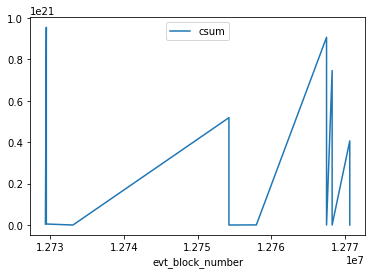

In [8]:
(df_mintburn_idx.loc[(199270, 199280, '0xC36442b4a4522E871399CD717aBDD847Ab11FE88'),: ]
    .assign(csum=lambda x: x.inp_amount.cumsum().astype(float))
    .plot('evt_block_number', 'csum')
)

### Appendix: check L2 data

In [9]:
with pool.ledger.events.Mint as q:
    mint_sel = q.select(columns=q.columns,
                    where=q.BLOCK_NUMBER.in_([12_730_140, 12_730_128])
                )
    df_mint_sel = mint_sel.to_dataframe()

with pool.ledger.events.Burn as q:
    burn_sel = q.select(columns=q.columns, # [q.EVT_BLOCK_NUMBER, q.AMOUNT],
                    where=q.BLOCK_NUMBER.in_([12_730_164])
                )
    df_burn_sel = burn_sel.to_dataframe()
display(df_mint_sel)
display(df_burn_sel)

,block_number,block_timestamp,contract_address,log_index,signature,transaction_hash,evt_sender,evt_owner,evt_tickLower,evt_tickUpper,evt_amount,evt_amount0,evt_amount1
0,12730128,1624985784,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,231,"Mint(address,address,int24,int24,uint128,uint2...",0x410d831e650c72d7fb35e0103080422dbdf3db5e7f61...,0xc36442b4a4522e871399cd717abdd847ab11fe88,0xc36442b4a4522e871399cd717abdd847ab11fe88,199240,199250,169740150647778960621,4003123503532,0
1,12730140,1624986057,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,33,"Mint(address,address,int24,int24,uint128,uint2...",0x686fc00cd1be127014a22f0a6ed86988260b000bccda...,0xc36442b4a4522e871399cd717abdd847ab11fe88,0xc36442b4a4522e871399cd717abdd847ab11fe88,199240,199250,144166551867123810923,3400000000000,0


,block_number,block_timestamp,contract_address,log_index,signature,transaction_hash,evt_owner,evt_tickLower,evt_tickUpper,evt_amount,evt_amount0,evt_amount1
0,12730164,1624986320,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,278,"Burn(address,int24,int24,uint128,uint256,uint256)",0x8ae8b23fdad1f95269b50bd612705a9d1b5904704ed1...,0xc36442b4a4522e871399cd717abdd847ab11fe88,199240,199250,313906702514902771544,1398840805707,2698285337840160706644


### Appendix: get event from node

In [10]:
df_burn_evt = (
    pd.DataFrame(pool.fetch_events(pool.events.Mint,
                       from_block=12730128,
                       to_block=12730128))
    .sort_values(['blockNumber', 'logIndex'])
    )
df_burn_evt

,args,event,logIndex,transactionIndex,transactionHash,address,blockHash,blockNumber,owner,tickLower,tickUpper,sender,amount,amount0,amount1
0,"(owner, tickLower, tickUpper, sender, amount, ...",Mint,231,109,b'A\r\x83\x1ee\x0cr\xd7\xfb5\xe0\x100\x80B-\xb...,0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640,"b'\xfb\xc4mDF\x99\xce\x03|\x93""\x11\x9c\x93\x1...",12730128,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,199240,199250,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,169740150647778960621,4003123503532,0


In [11]:
df_burn_evt = (
    pd.DataFrame(pool.fetch_events(pool.events.Mint,
                       from_block=12730140,
                       to_block=12730140))
    .sort_values(['blockNumber', 'logIndex'])
    )
df_burn_evt

,args,event,logIndex,transactionIndex,transactionHash,address,blockHash,blockNumber,owner,tickLower,tickUpper,sender,amount,amount0,amount1
0,"(owner, tickLower, tickUpper, sender, amount, ...",Mint,33,18,b'ho\xc0\x0c\xd1\xbe\x12p\x14\xa2/\nn\xd8i\x88...,0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640,b'\xf2\xc54\x0e\xc4\x8c\x1d\x16\xec\x92K\x88\x...,12730140,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,199240,199250,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,144166551867123810923,3400000000000,0


In [12]:
df_burn_evt = (
    pd.DataFrame(pool.fetch_events(pool.events.Burn,
                       from_block=12730164,
                       to_block=12730164))
    .sort_values(['blockNumber', 'logIndex'])
    )
df_burn_evt

,args,event,logIndex,transactionIndex,transactionHash,address,blockHash,blockNumber,owner,tickLower,tickUpper,amount,amount0,amount1
0,"(owner, tickLower, tickUpper, amount, amount0,...",Burn,278,245,b'\x8a\xe8\xb2?\xda\xd1\xf9Ri\xb5\x0b\xd6\x12p...,0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640,b'\xf5Nk\x89\xb7z(&\x07\x19\xcd\xca\xaf\xd6\x0...,12730164,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,199240,199250,313906702514902771544,1398840805707,2698285337840160706644


In [13]:
df_burn_evt = (
    pd.DataFrame(pool.fetch_events(pool.events.Burn,
                       from_block=12706340,
                       to_block=12706340))
    .sort_values(['blockNumber', 'logIndex']))
df_burn_evt

,args,event,logIndex,transactionIndex,transactionHash,address,blockHash,blockNumber,owner,tickLower,tickUpper,amount,amount0,amount1
0,"(owner, tickLower, tickUpper, amount, amount0,...",Burn,363,136,b'\x18i\x91 \xa5\xca\xceb\xa4Ql\xbd;\xfbF\x83w...,0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640,b'\xddT\\p\x8c\x1bp\xc3/SM\xb4Y\xad\xb18\x9c\x...,12706340,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,184790,201470,10029609425919843,3635005120,132406662882279247300
